# Simple ring parameter constraints

This notebook provides test cases for the precision of a simple lens model (with simplified assumptions). This is for show-casing and to assess the uncertainty limit in how well the parameters of this model can be constrained.


In [6]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

## simulation choices

In [63]:
# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 30.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size per axis
pixel_scale = 0.22  #  pixel size in arcsec (area per pixel = pixel_scale**2)
fwhm = 0.7  # full width at half maximum of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# lensing quantities
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': .66, 'center_x': 0.05, 'center_y': 0, 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

kwargs_lens = [kwargs_spemd, kwargs_shear]
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list)


# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)


kwargs_sersic_lens = {'amp': 16, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}

lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)


In [64]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': pixel_scale, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

C:\Users\eapel\AppData\Local\Temp\ipykernel_43788\2758023301.py:11: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, extent=[0, 1, 0, 1])


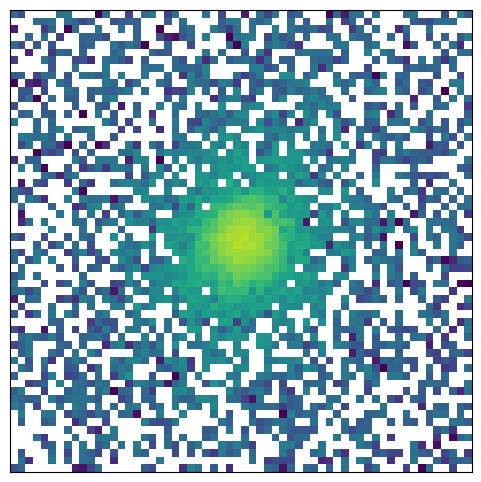

In [65]:
# display the initial simulated image
import matplotlib as mpl


v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [66]:
from astropy.io import fits
def gen_fits(data, filename):
    #data = data.astype(np., copy=False)
    fits.ImageHDU(data=data).writeto(f'conjunto_entrenamiento/{filename}.fits', overwrite=True)
    
gen_fits(image_real, 'er1')

## Model fitting
in the blocks above we simulated a mock lens with noise properties. From these cells, we only require the kwargs_data and kwargs_psf arguments to perform the modeling. If you have real data, you can leave out the image simulation and directly read in the data, PSF and noise properties into the keyword arguement list. Make sure the units are correct. Further information on the settings are available in the ImageData() and PSF() classes in the lenstronomy.Data module.

In [67]:
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append({'theta_E': 0.7, 'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2, 'amp': 10})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10, 'amp': 100})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1, 'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10, 'amp': 100})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


In [69]:
kwargs_likelihood = {'source_marg': False}
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
# if you have multiple  bands to be modeled simultaneously, you can append them to the mutli_band_list
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'single-band'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }
kwargs_constraints = {'linear_solver': True}  # optional, if 'linear_solver': False, lenstronomy does not apply a linear inversion of the 'amp' parameters during fitting but instead samples them.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers': 200, 'sigma_scale': .1}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-1.8911380120450159 reduced X^2 of best position
-3384.1914725545557 log likelihood
3579 effective number of data points
[{'theta_E': 0.6052680223071474, 'e1': 0.009624784282876346, 'e2': -0.06046227542474203, 'center_x': 0.036054745889963956, 'center_y': -0.08517263996361428}, {'gamma1': -0.04245860169417328, 'gamma2': -0.06492522445041084, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.5862203195755161, 'n_sersic': 4.991570886026748, 'e1': 0.0872339670960466, 'e2': 0.2456880505123523, 'center_x': 0.04957189949869216, 'center_y': -0.08450357086211206}] source result
[{'amp': 1, 'R_sersic': 0.8799159088681029, 'n_sersic': 4.995816093204779, 'e1': -0.2612264051752133, 'e2': 0.018544019938297393, 'center_x': 0.11073494716385868, 'center_y': -0.10967350417320197}] lens light result
[] point source result
[] tracer source result
{} special param resul

You must install the tqdm library to use progress indicators with emcee


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  200
Sampling iterations (in current run): 800
80.46304821968079 time taken for MCMC sampling


## analyse MCMC chain

-1.878341857744834 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.878341857744834


C:\Users\eapel\AppData\Local\Temp\ipykernel_43788\2482781546.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


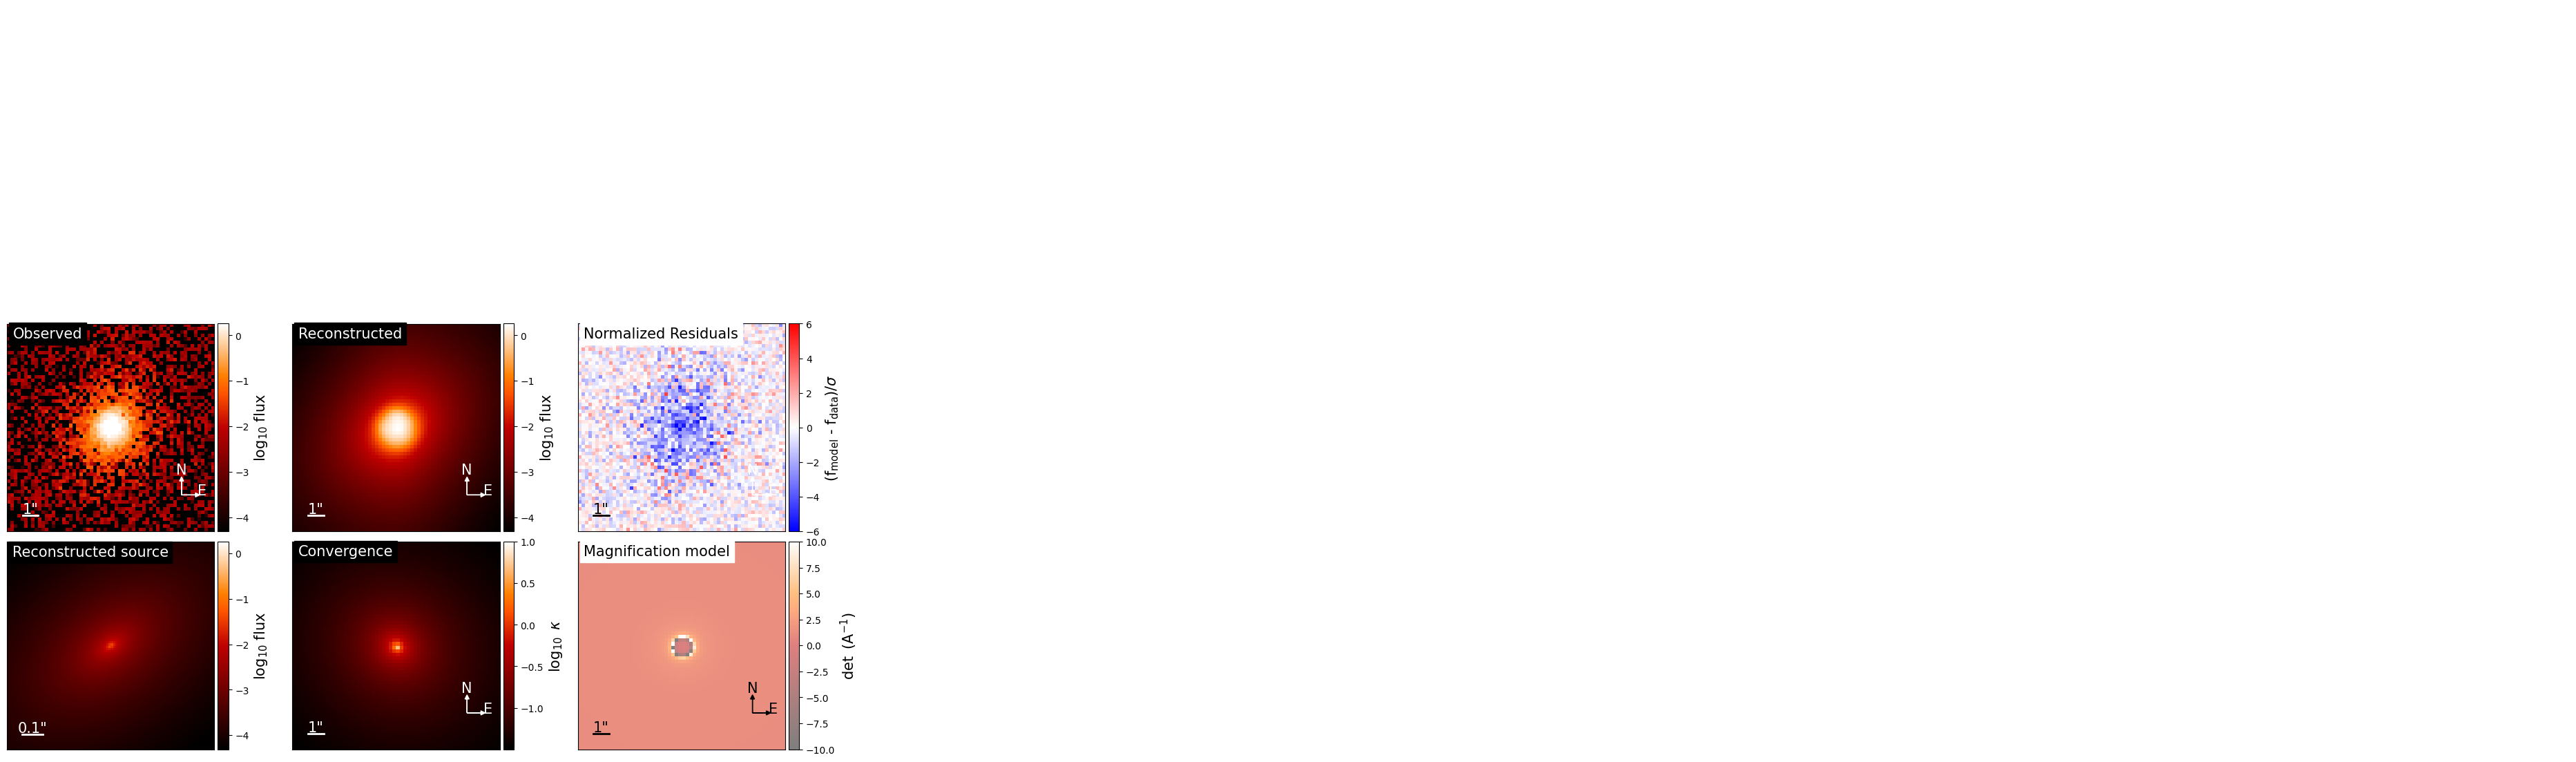

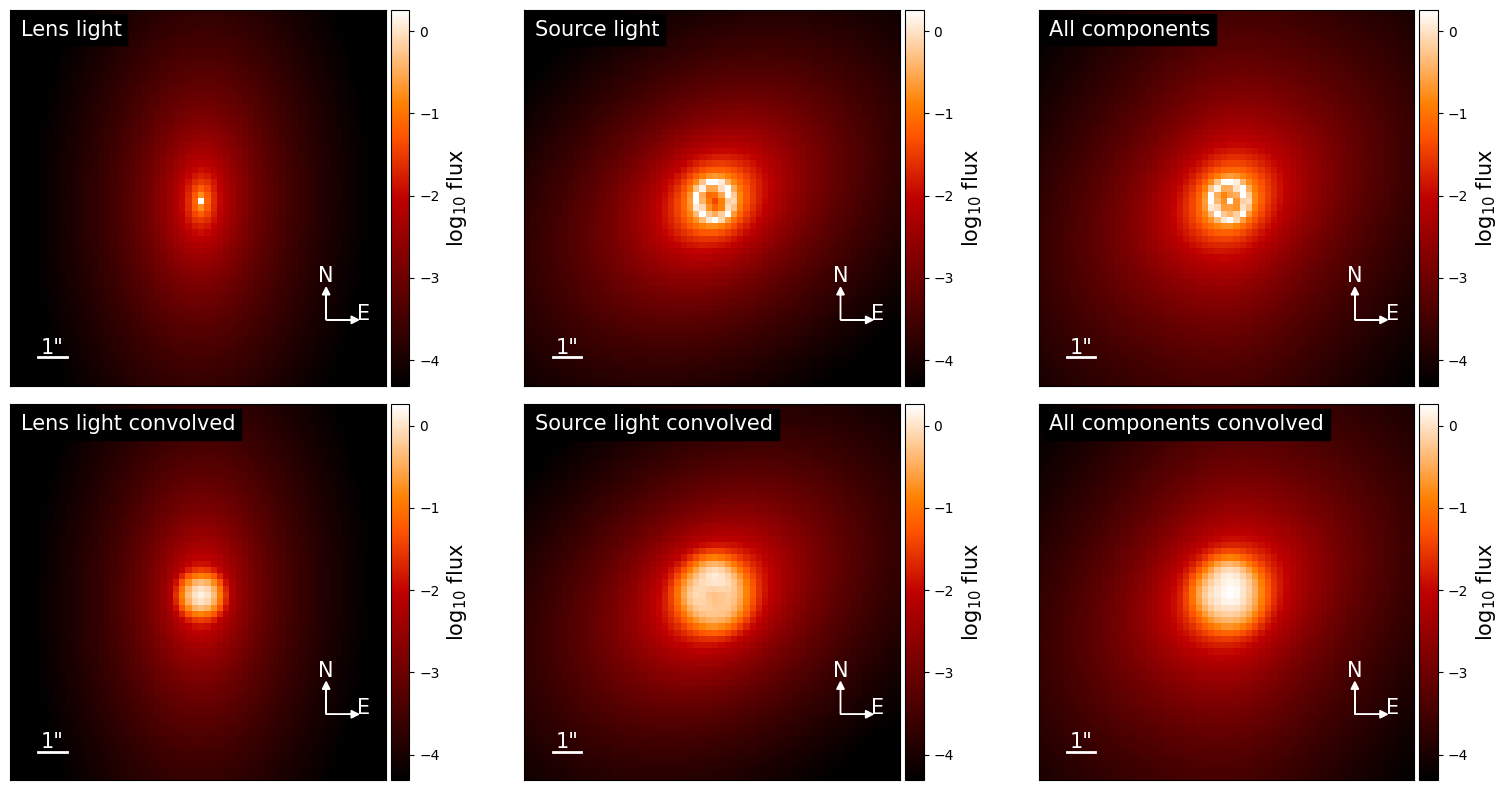

{'kwargs_lens': [{'theta_E': 0.6077887522149584, 'e1': 0.017728311339555526, 'e2': -0.03838297378703351, 'center_x': 0.05121000869621478, 'center_y': -0.08022730731259521}, {'gamma1': -0.026311416318093965, 'gamma2': -0.04733461671506607, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1.0741204806089442, 'R_sersic': 0.5565545726177613, 'n_sersic': 4.956157358162256, 'e1': 0.08377061070364661, 'e2': 0.21844320852554885, 'center_x': 0.06607896360219498, 'center_y': -0.08259915307569816}], 'kwargs_lens_light': [{'amp': 0.22870697968536538, 'R_sersic': 0.863723277762912, 'n_sersic': 4.997239397062844, 'e1': -0.2832043728288674, 'e2': 0.017741810760236447, 'center_x': 0.10965271928349912, 'center_y': -0.11079457790026821}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


In [70]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat",
                     linear_solver=kwargs_constraints.get('linear_solver', True))
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  120000
120000


ValueError: operands could not be broadcast together with shapes (120000,19) (0,) 

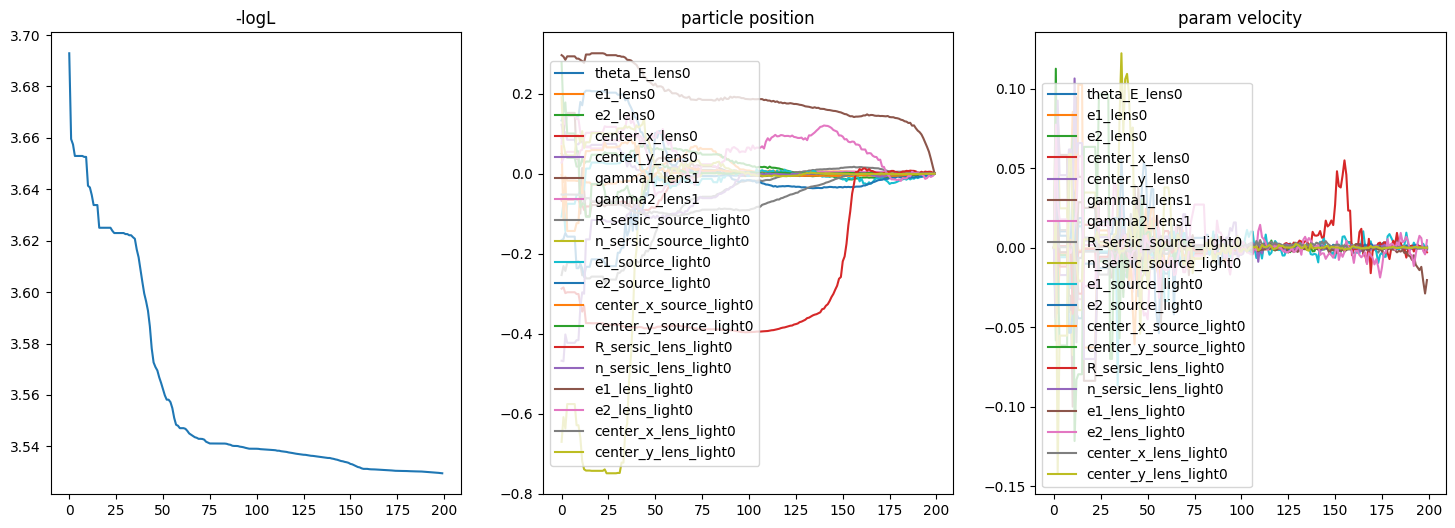

<Figure size 640x480 with 0 Axes>

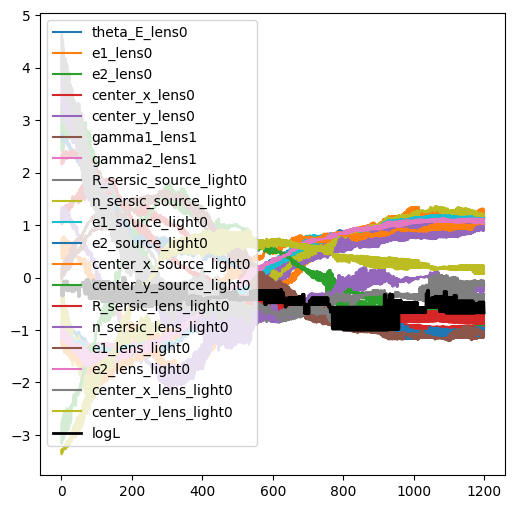

In [71]:
# the results of the MCMC chain

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

param_class = fitting_seq.param_class
param_truths = param_class.kwargs2args(kwargs_lens=kwargs_lens, kwargs_source=kwargs_source, kwargs_lens_light=kwargs_lens_light)

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
n_sample = len(samples_mcmc)
print(n_sample)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]
if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:], show_titles=True, truths=param_truths)
